In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import plotly.express as px
import random
from keras.losses import SparseCategoricalCrossentropy


In [3]:
def fetch_image(data_folder):
    train_data = []
    test_data = []
    valid_data = []
    
    splits = {
        "train": os.path.join(data_folder, "train"),
        "test": os.path.join(data_folder, "test"),
        "valid": os.path.join(data_folder, "valid")
    }
    
    for split_name, split_path in splits.items():
        images_folder = os.path.join(split_path, "images")
        labels_folder = os.path.join(split_path, "labels")
        
        for image_name in os.listdir(images_folder):
            label_name = os.path.splitext(image_name)[0] + ".txt"
            label_path = os.path.join(labels_folder, label_name)
            image_path = os.path.join(images_folder, image_name)
            
            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_name}")
                continue
            
            imgTrafficSignal = Image.open(image_path)
            imgTrafficSignal = imgTrafficSignal.convert("L")
            imgTrafficSignal = imgTrafficSignal.resize((90, 90))
            imgTrafficSignal = np.array(imgTrafficSignal)
            
            with open(label_path, "r") as label_file:
                label_lines = label_file.readlines()
                label_values = []
                for line in label_lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])  # First value is the class ID
                    label_values.append(class_id)
            
            # Use only valid labels (remove -1 or any invalid labels)
            valid_labels = [label for label in label_values if label >= 0]
            
            if not valid_labels:
                print(f"No valid labels for {image_name}")
                continue
            
            # Use the first valid label
            first_label = valid_labels[0]
            
            if split_name == "train":
                train_data.append((imgTrafficSignal, first_label))
            elif split_name == "test":
                test_data.append((imgTrafficSignal, first_label))
            elif split_name == "valid":
                valid_data.append((imgTrafficSignal, first_label))
    
    return train_data, test_data, valid_data

In [4]:
data_folder = "./DataSet"
train_data, test_data, valid_data = fetch_image(data_folder)

No valid labels for FisheyeCamera_1_00802_png.rf.6a502d781364b74f35bfa71832fc1ede.jpg
No valid labels for FisheyeCamera_1_00807_png.rf.065f778b2eaf15dd7b5beb90b30c490c.jpg
No valid labels for FisheyeCamera_1_00926_png.rf.511cfac04ff48a1fe99b560b4a4fb9e2.jpg
No valid labels for FisheyeCamera_1_00922_png.rf.408835a278b9c700eb1a2f358ca58d07.jpg


In [5]:
# Prepare training data features and labels
training_data_features, training_data_labels = zip(*train_data)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)

# Normalize the images
training_data_features = training_data_features / 255.0

# Reshape for CNN (add channel dimension)
training_data_features = training_data_features.reshape(-1, 90, 90, 1)

In [6]:
cnnModel = Sequential()
cnnModel.add(Conv2D(16,(3,3), padding="same", input_shape=(90, 90, 1), activation='relu'))
print(cnnModel(training_data_features).shape)
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(32,(3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(64,(5,5), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(128,(7,7), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Flatten())
cnnModel.add(Dense(232, activation='relu'))
cnnModel.add(Dense(116, activation='relu'))
cnnModel.add(Dense(58, activation='softmax'))

C:\Users\manou\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(3527, 90, 90, 16)


In [7]:
cnnModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 90, 90, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 45, 45, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 23, 23, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 232)                 │       1,069,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 116)                 │          27,028 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 58)                  │           6,786 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,560,702 (5.95 MB)

 Trainable params: 1,560,702 (5.95 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
cnnModel.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [9]:
# Prepare validation data
validation_data_features, validation_data_labels = zip(*valid_data)
validation_data_features = np.array(validation_data_features)
validation_data_labels = np.array(validation_data_labels)

# Normalize validation images
validation_data_features = validation_data_features / 255.0
validation_data_features = validation_data_features.reshape(-1, 90, 90, 1)

# Train the model
history = cnnModel.fit(
    training_data_features, 
    training_data_labels, 
    validation_data=(validation_data_features, validation_data_labels),
    epochs=12, 
    batch_size=32
)

Epoch 1/12


C:\Users\manou\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.0829 - loss: 2.9394 - val_accuracy: 0.1348 - val_loss: 2.5750
Epoch 2/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.1648 - loss: 2.4982 - val_accuracy: 0.2996 - val_loss: 2.1442
Epoch 3/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.2944 - loss: 2.1517 - val_accuracy: 0.3233 - val_loss: 1.9690
Epoch 4/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.3642 - loss: 1.9199 - val_accuracy: 0.3920 - val_loss: 1.8441
Epoch 5/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.4405 - loss: 1.6543 - val_accuracy: 0.4270 - val_loss: 1.6857
Epoch 6/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.5298 - loss: 1.4216 - val_accuracy: 0.4719 - val_loss: 1.5601
Epoch 7/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6118 - loss: 1.1827 - val_accuracy: 0.5543 - val_loss: 1.4717
Epoch 8/12
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.6864 - loss: 0.9034 - val_accuracy: 0.

In [21]:
test_data_features, test_data_labels = zip(*test_data)
test_data_features = np.array(test_data_features)
test_data_labels = np.array(test_data_labels)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


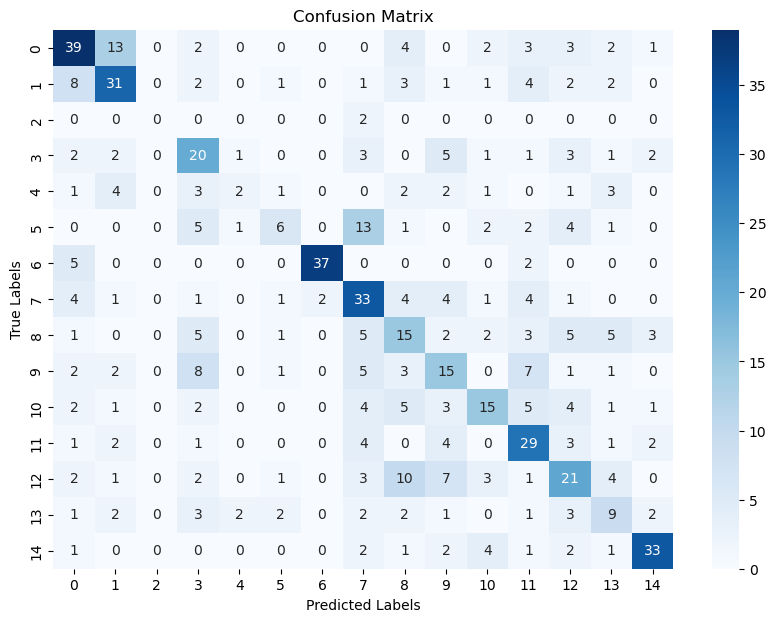

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels on the test data
test_predictions = cnnModel.predict(test_data_features)
# Convert predictions from probabilities to class labels (use argmax to get the index of the highest probability)
test_predictions = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_data_labels, test_predictions)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_data_labels), yticklabels=np.unique(test_data_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [27]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for multi-class classification
cm = confusion_matrix(test_data_labels, test_predictions)

# For each class (row/column), compute TP, TN, FP, FN
for i in range(cm.shape[0]):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp  # sum of the column - TP
    fn = cm[i, :].sum() - tp  # sum of the row - TP
    tn = cm.sum() - (tp + fp + fn)
    
    print(f"Class {i}:")
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative (TN): {tn}")
    print()

Class 0:
True Positive (TP): 39
False Positive (FP): 30
False Negative (FN): 30
True Negative (TN): 538

Class 1:
True Positive (TP): 31
False Positive (FP): 28
False Negative (FN): 25
True Negative (TN): 553

Class 2:
True Positive (TP): 0
False Positive (FP): 0
False Negative (FN): 2
True Negative (TN): 635

Class 3:
True Positive (TP): 20
False Positive (FP): 34
False Negative (FN): 21
True Negative (TN): 562

Class 4:
True Positive (TP): 2
False Positive (FP): 4
False Negative (FN): 18
True Negative (TN): 613

Class 5:
True Positive (TP): 6
False Positive (FP): 8
False Negative (FN): 29
True Negative (TN): 594

Class 6:
True Positive (TP): 37
False Positive (FP): 2
False Negative (FN): 7
True Negative (TN): 591

Class 7:
True Positive (TP): 33
False Positive (FP): 44
False Negative (FN): 23
True Negative (TN): 537

Class 8:
True Positive (TP): 15
False Positive (FP): 35
False Negative (FN): 32
True Negative (TN): 555

Class 9:
True Positive (TP): 15
False Positive (FP): 31
False Ne

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics for each class
for i in range(cm.shape[0]):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp  # sum of the column - TP
    fn = cm[i, :].sum() - tp  # sum of the row - TP
    tn = cm.sum() - (tp + fp + fn)
    
    # Calculate Precision, Recall, F1-Score, and Accuracy
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Class {i}:")
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative (TN): {tn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print()


Class 0:
True Positive (TP): 39
False Positive (FP): 30
False Negative (FN): 30
True Negative (TN): 538
Precision: 0.5652
Recall: 0.5652
F1-Score: 0.5652
Accuracy: 0.9058

Class 1:
True Positive (TP): 31
False Positive (FP): 28
False Negative (FN): 25
True Negative (TN): 553
Precision: 0.5254
Recall: 0.5536
F1-Score: 0.5391
Accuracy: 0.9168

Class 2:
True Positive (TP): 0
False Positive (FP): 0
False Negative (FN): 2
True Negative (TN): 635
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Accuracy: 0.9969

Class 3:
True Positive (TP): 20
False Positive (FP): 34
False Negative (FN): 21
True Negative (TN): 562
Precision: 0.3704
Recall: 0.4878
F1-Score: 0.4211
Accuracy: 0.9137

Class 4:
True Positive (TP): 2
False Positive (FP): 4
False Negative (FN): 18
True Negative (TN): 613
Precision: 0.3333
Recall: 0.1000
F1-Score: 0.1538
Accuracy: 0.9655

Class 5:
True Positive (TP): 6
False Positive (FP): 8
False Negative (FN): 29
True Negative (TN): 594
Precision: 0.4286
Recall: 0.1714
F1-Score: 